<a href="https://colab.research.google.com/github/shadowscythe03/es335-24-fall-assignment-2/blob/master/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(Remove at last): For GPU, write .to(device) else just remove all of it

In [68]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [69]:
if os.path.exists("/content/road-8284023_1280.jpg"):
  print("Image is at this path: /content/road-8284023_1280.jpg")

Image is at this path: /content/road-8284023_1280.jpg


In [70]:
img = torchvision.io.read_image("/content/road-8284023_1280.jpg")
print(img.shape)

torch.Size([3, 1280, 852])


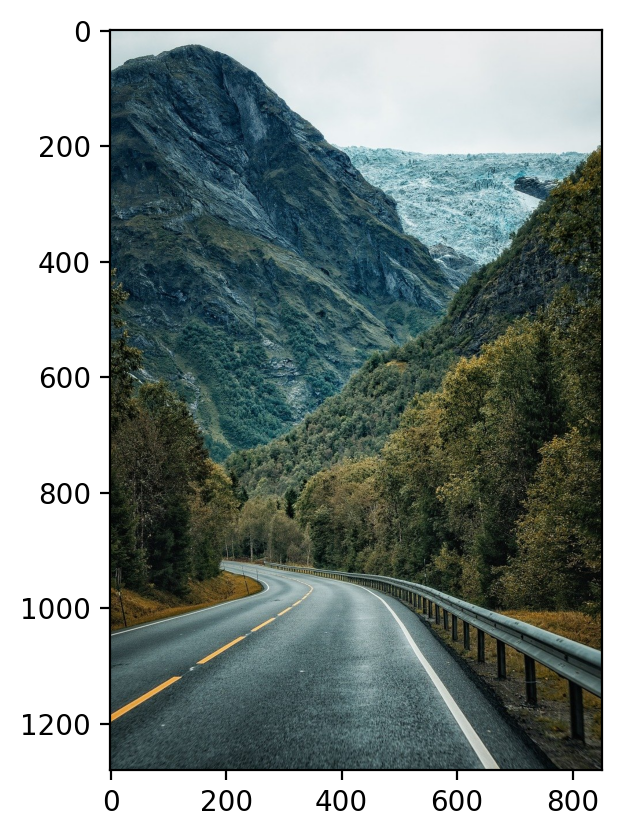

In [71]:
plt.imshow(rearrange(img, 'b h w -> h w b').numpy())

In [72]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [73]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)) #converts to 1D array of 3*h*w 3 is channels
img_scaled = img_scaled.reshape(img.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled.shape

torch.Size([3, 1280, 852])

In [74]:
cropped_image = torchvision.transforms.functional.crop(img_scaled.cpu(), 200, 400, 300, 300)
cropped_image.to(device)
cropped_image.shape

torch.Size([3, 300, 300])

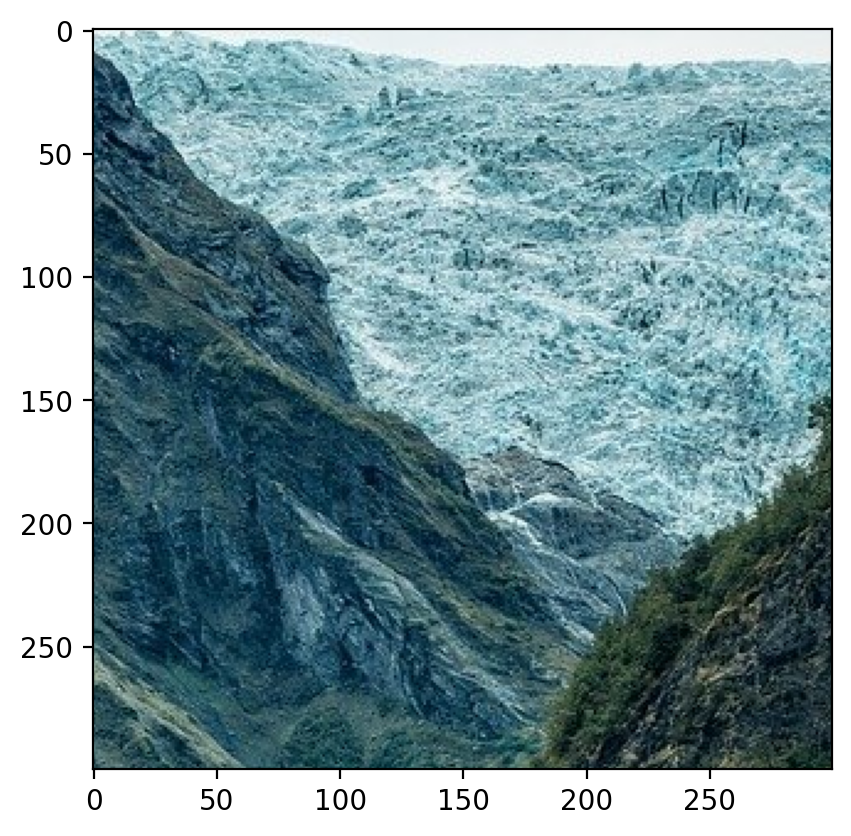

In [75]:
plt.imshow(rearrange(cropped_image, 'c h w -> h w c').cpu().numpy())

In [76]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).to(torch.float32)

    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').to(torch.float32)
    return X, Y

In [77]:
road_X, road_Y = create_coordinate_map(cropped_image)
road_X.shape, road_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [78]:
#Uncomment for GPU:
road_Y = torch.tensor(road_Y).to(device) #delete for gpu

road_X is (X,Y) vales. road_Y is (no.of (X,Y),channels)

In [79]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X.cpu())  #road_X will work for GPU, but sklearn is for cpu

# Scale the X coordinates
road_X_scaled = scaler_X.transform(road_X.cpu())

# Move the scaled X coordinates to the GPU
road_X_scaled = torch.tensor(road_X_scaled).to(device)

# Set to dtype float32
road_X_scaled = road_X_scaled.to(torch.float32)

In [80]:
road_X_scaled[59909:59919]

tensor([[0.3311, 0.3980],
        [0.3311, 0.4047],
        [0.3311, 0.4114],
        [0.3311, 0.4181],
        [0.3311, 0.4247],
        [0.3311, 0.4314],
        [0.3311, 0.4381],
        [0.3311, 0.4448],
        [0.3311, 0.4515],
        [0.3311, 0.4582]], device='cuda:0')

In [81]:
road_Y[59909:59919]

tensor([[0.2118, 0.3608, 0.4039],
        [0.2941, 0.4431, 0.4863],
        [0.3333, 0.4824, 0.5255],
        [0.2431, 0.3922, 0.4353],
        [0.1412, 0.2902, 0.3255],
        [0.3451, 0.4941, 0.5373],
        [0.3961, 0.5451, 0.5804],
        [0.3686, 0.5098, 0.5569],
        [0.1373, 0.2784, 0.3255],
        [0.1686, 0.3098, 0.3569]], device='cuda:0')

In [82]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [83]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [84]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ##Now plotting for original image

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [85]:
def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int

    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]  #1st column or feature
    X2 = X[:, 1]  #2nd column or feature

    X1 = X1.unsqueeze(1)  #making it in shape of (90000,1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)  #Concatenating along column

    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())

    return torch.tensor(X, dtype=torch.float32).to(device)

In [86]:
road_X_scaled_poly = poly_features(road_X_scaled, 50)
road_X_scaled_poly.dtype, road_X_scaled_poly.shape, road_Y.shape, road_Y.dtype

(torch.float32,
 torch.Size([90000, 1326]),
 torch.Size([90000, 3]),
 torch.float32)

In [87]:
net = LinearModel(road_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, road_X_scaled_poly, road_Y, 1500)

Epoch 0 loss: 0.303522
Epoch 100 loss: 0.027656
Epoch 200 loss: 0.023645
Epoch 300 loss: 0.022451
Epoch 400 loss: 0.021847
Epoch 500 loss: 0.021491
Epoch 600 loss: 0.021253
Epoch 700 loss: 0.021075
Epoch 800 loss: 0.020933
Epoch 900 loss: 0.020813
Epoch 1000 loss: 0.020709
Epoch 1100 loss: 0.020618
Epoch 1200 loss: 0.020537
Epoch 1300 loss: 0.020519
Epoch 1400 loss: 0.020400


0.02034350298345089

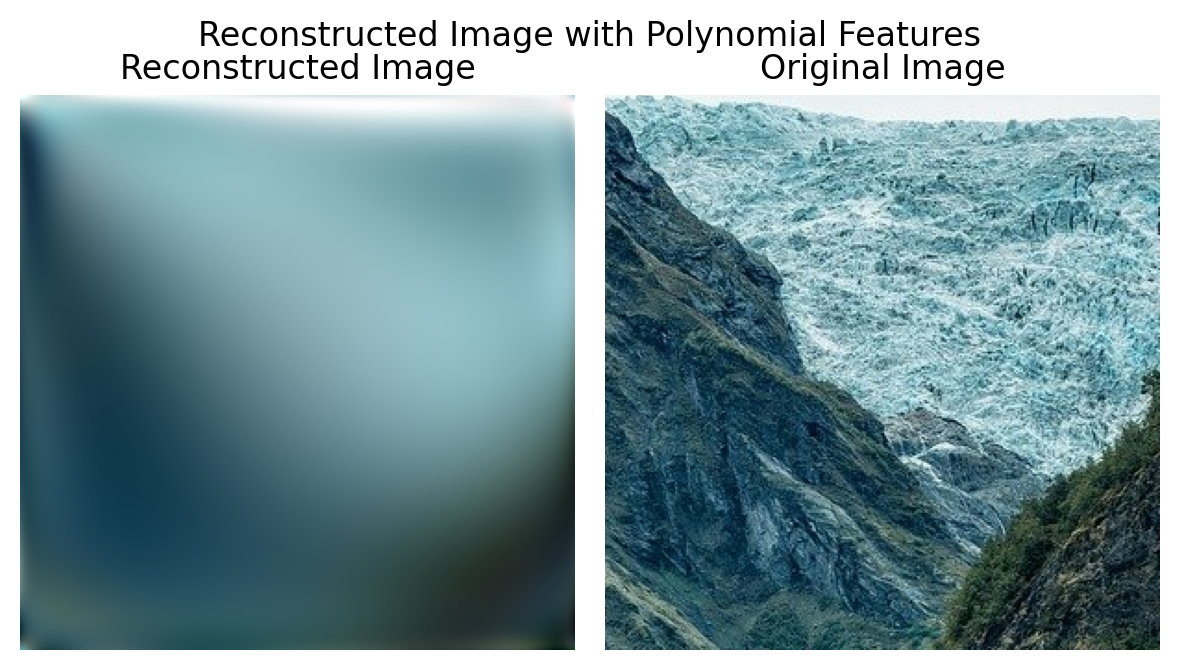

In [88]:
plot_reconstructed_and_original_image(cropped_image, net, road_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

Creating RFF features

In [89]:
def create_rff_features(X, num_features, sigma, device, batch_size=10000):
    n_samples, n_features = X.shape

    # Generate random weights and bias for RFF (weights can be large, so precompute and store on GPU)
    W = torch.randn(n_features, num_features, device=device) / sigma  # Random Gaussian weights
    b = 2 * torch.pi * torch.rand(num_features, device=device)  # Random bias

    Z_list = []  # Store the chunks of transformed data

    # Process the input in smaller batches to reduce memory usage
    for i in range(0, n_samples, batch_size):
        X_batch = X[i:i + batch_size]  # Slice the batch from the input tensor
        Z_batch = torch.matmul(X_batch, W) + b  # Linear transformation
        Z_batch = torch.cos(Z_batch) * (2.0 / torch.sqrt(torch.tensor(num_features, dtype=torch.float32, device=device)))  # Apply cosine and normalize
        Z_list.append(Z_batch)

    # Concatenate all the processed batches to form the final tensor
    Z = torch.cat(Z_list, dim=0)

    return Z

In [90]:
X_rff = create_rff_features(road_X_scaled, 10000, 0.008, device)

In [91]:
net = LinearModel(X_rff.shape[1], 3)    #same as 2, 3 only
net.to(device)

train(net, 0.005, X_rff, road_Y, 2500)

Epoch 0 loss: 0.281027
Epoch 100 loss: 0.055456
Epoch 200 loss: 0.042172
Epoch 300 loss: 0.038695
Epoch 400 loss: 0.036283
Epoch 500 loss: 0.034448
Epoch 600 loss: 0.032984
Epoch 700 loss: 0.031774
Epoch 800 loss: 0.030748
Epoch 900 loss: 0.029857
Epoch 1000 loss: 0.029069
Epoch 1100 loss: 0.028362
Epoch 1200 loss: 0.027718
Epoch 1300 loss: 0.027125
Epoch 1400 loss: 0.026573
Epoch 1500 loss: 0.026055
Epoch 1600 loss: 0.025566
Epoch 1700 loss: 0.025101
Epoch 1800 loss: 0.024657
Epoch 1900 loss: 0.024231
Epoch 2000 loss: 0.023823
Epoch 2100 loss: 0.023431
Epoch 2200 loss: 0.023054
Epoch 2300 loss: 0.022691
Epoch 2400 loss: 0.022342


0.022010160610079765

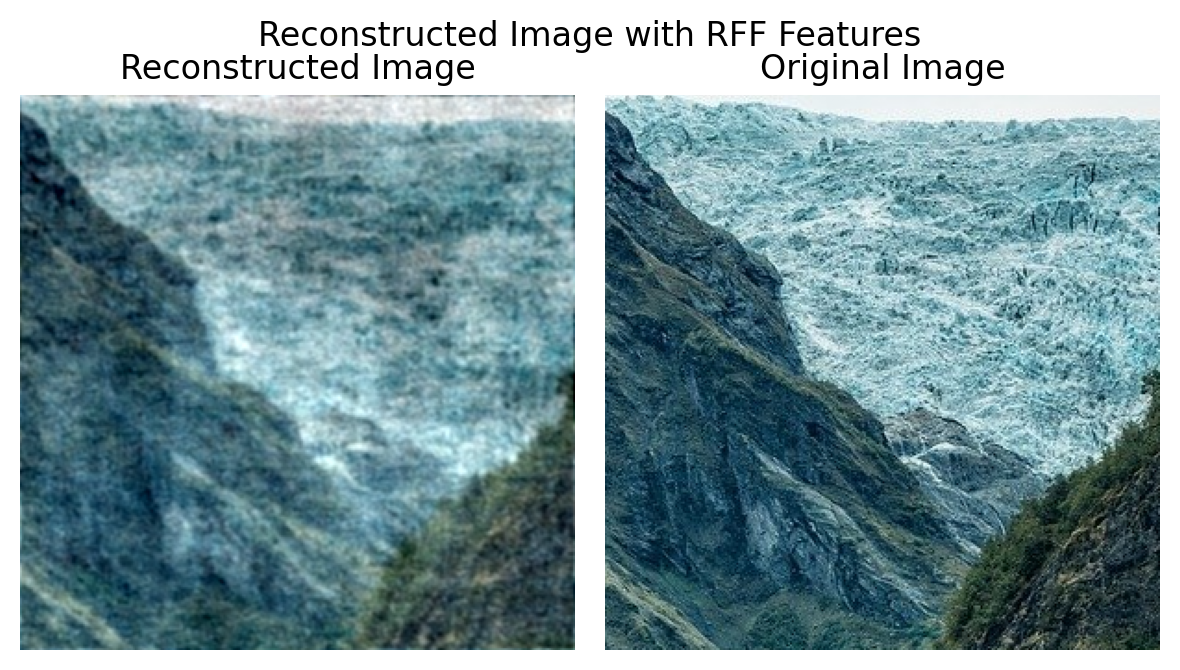

In [92]:
plot_reconstructed_and_original_image(cropped_image, net, X_rff, title="Reconstructed Image with RFF Features")